# Пример подгонки  произвольной функции к данным Zabbix.

Шаблон кода для работы с zabbix и прогнозирования процессов по-сисадмински.

In [1]:
import pandas as pd

При экспорте данных из веб-интерфейса zabbix доступна только выгрузка в виде текстового файла со странички,  однако применив некоторые параметры, данные можно считать  как CSV.

In [2]:
exp=pd.read_csv('exported.txt',sep=' ',skiprows=2,names=['day','time','unixts','value'])
exp

,day,time,unixts,value
0,2020-12-02,03:59:55,1606870795,416476
1,2020-12-02,03:56:56,1606870616,417435
2,2020-12-02,03:53:55,1606870435,417807
3,2020-12-02,03:50:55,1606870255,418295
4,2020-12-02,03:47:55,1606870075,418868
...,...,...,...,...
995,2020-11-30,02:14:55,1606691695,761883
996,2020-11-30,02:11:55,1606691515,762019
997,2020-11-30,02:08:55,1606691335,762278
998,2020-11-30,02:05:55,1606691155,762310


In [3]:
exp['ts']=exp.day + ' '  + exp.time
exp=exp.sort_values(by=['ts'])
exp.reset_index(drop=True, inplace=True)

In [4]:
exp['ts']=pd.to_datetime(exp.ts)
exp=exp[['ts','value']]
exp

,ts,value
0,2020-11-30 02:02:55,762904
1,2020-11-30 02:05:55,762310
2,2020-11-30 02:08:55,762278
3,2020-11-30 02:11:55,762019
4,2020-11-30 02:14:55,761883
...,...,...
995,2020-12-02 03:47:55,418868
996,2020-12-02 03:50:55,418295
997,2020-12-02 03:53:55,417807
998,2020-12-02 03:56:56,417435


Посмотрим на исходные данные графически

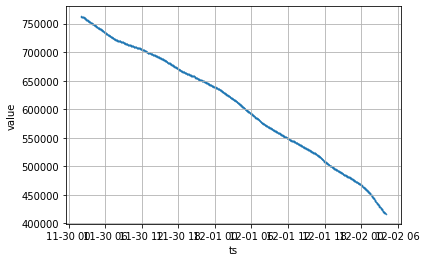

In [5]:
ax = exp.plot.scatter(x='ts',y='value',s=0.3,grid=True);

In [6]:
import datetime

In [7]:
# определимся с начальным временем и конвертируем даты в числа
timestart=pd.to_datetime('2020-11-29 0:0')
tsdayrow=((exp['ts']-timestart)/datetime.timedelta(days=1)).copy()

In [8]:
exp.loc[:,'tsdayrow']=tsdayrow.copy()

In [9]:
exp

,ts,value,tsdayrow
0,2020-11-30 02:02:55,762904,1.085359
1,2020-11-30 02:05:55,762310,1.087442
2,2020-11-30 02:08:55,762278,1.089525
3,2020-11-30 02:11:55,762019,1.091609
4,2020-11-30 02:14:55,761883,1.093692
...,...,...,...
995,2020-12-02 03:47:55,418868,3.158275
996,2020-12-02 03:50:55,418295,3.160359
997,2020-12-02 03:53:55,417807,3.162442
998,2020-12-02 03:56:56,417435,3.164537


<AxesSubplot:xlabel='tsdayrow'>

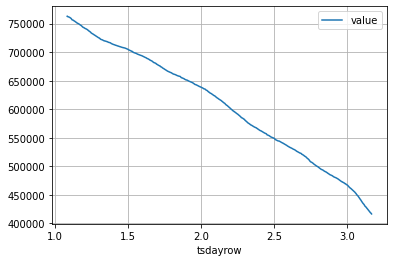

In [10]:
# убедимся что время можно интерпретировать как число дней
exp.plot(x='tsdayrow',y='value',grid=True)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## выбор функции 
рисуем простой график функции на основе экспоненты чтобы убедиться что функция в принципе нам подходит по форме

In [12]:
def func(x, a, b, c):
    return a * np.exp(b*x) +c

Проверим соответствует ли код предполагаемой форме графика функции? 

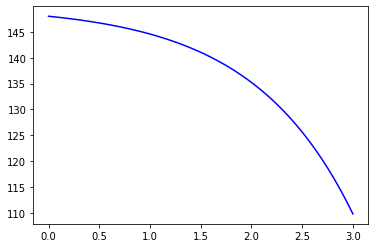

In [13]:
xdata = np.linspace(0, 3, 50)
y = func(xdata, - 2, 1, 150)
plt.plot(xdata, y, 'b-', label='data');

теперь на основе экспериментальных данных подтянем функцию с помощью метода scipy.optimize.curve_fit()

In [14]:
popt,pcov = curve_fit(func,exp['tsdayrow'],exp['value'])
popt

array([-3.53000475e+05,  2.56810198e-01,  1.22341800e+06])

In [15]:
pcov

array([[ 9.94239082e+07,  4.61300334e+01, -1.10580720e+08],
       [ 4.61300334e+01,  2.14442307e-05, -5.12502284e+01],
       [-1.10580720e+08, -5.12502284e+01,  1.23080280e+08]])


Снова графически отображаем чтобы убедиться что полученная функция подходит под данные

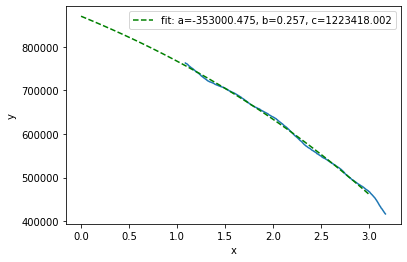

<Figure size 1440x720 with 0 Axes>

In [16]:
plt.plot(exp['tsdayrow'],exp['value'])

plt.plot(xdata, func(xdata, *popt), 'g--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.figure(figsize=(20,10))
plt.show()

## TODO ## 
Еще посчитаем среднеквадратичную ошибку. Это пригодится для сравнения этой модели с другими  

# Прогноз на N дней вперед #

In [17]:
to_days=6
bins=500
xdata = np.linspace(0, to_days, bins)
y = func(xdata, *popt)

В какой же точке функция достигает 0 ?

In [22]:
thisday=xdata[np.argmax(y<=0)]
thisday

4.845691382765531

In [23]:
# и пересчитаем число в конктретную дату
thisday_str=str(timestart+pd.Timedelta(days=thisday))
thisday_str

'2020-12-03 20:17:47.735470941'

In [20]:
lastknown_x=exp['tsdayrow'][-1:]
lastknown_y=exp['value'][-1:]
lastknown_time=exp['ts'][-1:]

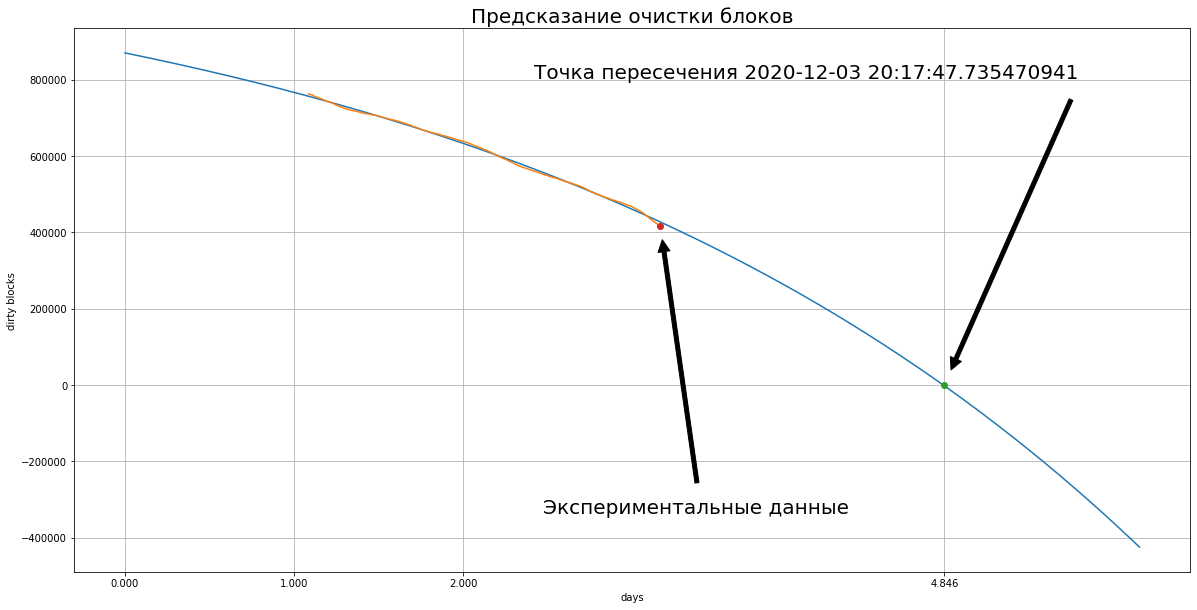

In [21]:
# отобразим графически
fig, ax = plt.subplots()
ax.plot(xdata, y)
fig.set_size_inches(20,10)
ax.set_title('Предсказание очистки блоков',fontsize=20)
ax.set_ylabel('dirty blocks')
ax.set_xlabel('days')
ax.grid('both')

ax.annotate('Точка пересечения ' + thisday_str,
            xy=(thisday, 0), xycoords='data',
            xytext=(0.9, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',fontsize=20)

ax.annotate('Экспериментальные данные ',
            xy=(lastknown_x, lastknown_y), xycoords='data',
            xytext=(0.7, 0.1), 
            textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',fontsize=20
           )


ax.set_xticks([0,1,2,thisday]);

# И поверх еще заполируем оригинальными данными
ax.plot(exp['tsdayrow'],exp['value'])
ax.plot(thisday, 0, 'o');
ax.plot(lastknown_x,lastknown_y,'o');


# Кстати #
С течением времени выяснилось, что исследуемый процесс линейный с поправками на суточную сезонность, но не экспоненциальный.